## Описание VLM, их устройство и архитектура

**Выбранная VLM: BLIP**


**Использованные данные для тренировки модели: COCO, Visual Genome, Conceptual Captions, Conceptual 12M, SBU Captions, LAION.**


**Размер модели: ~224M**


**Инференс модели: BlipProcessor позволяет быстро получить текстовое представление на CPU. Однако Processor для картинок не имеет возможности декодировать изначальные картинки(но это можно сделать вручную).**


**Дообучение: производится стандартно. Позволяет заморозить любой слой, дообучить на персональных данных**


**Устройство BLIP**

Двойной энкодер: Включает отдельные энкодеры для обработки текста и изображений.

Визуальный энкодер: Обычно основан на модели Vision Transformer (ViT), которая предназначена для извлечения признаков из изображений. ViT разбивает изображение на патчи (маленькие части) и обрабатывает их через несколько слоев трансформеров.

Текстовый энкодер: Чаще всего основан на трансформере BERT или его модификациях, чтобы эффективно обрабатывать текстовые данные.

Кросс-энкодер: После того как текст и изображение обработаны отдельно энкодерами, кросс-энкодер объединяет их представления, чтобы установить взаимосвязь между ними. Этот модуль позволяет модели отвечать на вопросы по изображению, генерировать описание и связывать объекты на изображении с текстом.

Используется смесь энкодеров-декодеров, которая может работать в одном из трех режимов:

1. Unimodal encoder: кодирует картинки и текст

2. Image-grounded text encoder: вводит визуальную информацию вставляя один дополнительный слой cross-attention между self-attention и FFN для каждого блока из трансформера из текстового энкодера

3. Image-grounded text decoder: заменяет двунаправленный self-attention в кодировщик текста на основе изображений со слоями self-attention


Для каждой пары изображение-текст требуется только один прямой проход через визуальный преобразователь, требующий больших вычислительных затрат, и три прямых прохода через текстовый преобразователь, где активируются различные функциональные возможности для вычисления трех потерь, а именно:

1. Image-Text Contrastive Loss (ITC) активирует Unimodal encoder. Нужен для сопоставления эмбеддингов текста и изображений

2. Image-Text Matching Loss (ITM) активирует Image-grounded text encoder. Он направлен на изучение мультимодального представления изображения и текста. 

3. Language Modeling Loss (LM) активирует Image-grounded text decoder. Нужен для генерации текстовые описания для картинок.

![](https://imgur.com/ZciTKj9.jpeg)



**Источник:** [BLIP Explained](https://arxiv.org/pdf/2201.12086)

## Базовое устройство архитектуры VLM

Существуют различные способы предварительной подготовки модели vision language. В основном, чтобы объединить изображение и текстовое представление и передать их в текстовый декодер для генерации. Наиболее распространенные и известные модели часто состоят из кодировщика изображений, встроенного проектора для выравнивания изображений и текстовых представлений  и текстового декодера, расположенных в таком порядке. Что касается обучающих частей, то разные модели используют разные подходы.

![](https://imgur.com/o4eUaOA.jpeg)

![](https://imgur.com/LteUTDL.jpeg)

**Источник:** [VLM models Explained](https://huggingface.co/blog/vlms)

## Загрузка модели и процессора

In [1]:
import transformers
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Создаем датасет

В качестве датасета выбран один из стандартных: [ChartQA](https://aclanthology.org/2022.findings-acl.177.pdf). 

Он состоит из картинок, вопросов и ответов на них. Представлены различные графики: столбчатые, линейные, диаграммы и другие. Так как модель является небольшой(BLIP), то решено взять относительно простую задачу VQA по графикам. Модель BLIP обучена так, что она хорошо понимает контекстное представление картинки и понимает, что представлено на них.

In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from torchvision import transforms
import numpy as np
from PIL import Image
class VQADataset(Dataset):
    def __init__(self, data,text_processor,image_processor):
        self.data = data
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image'].convert('RGB')
        questions = self.data[idx]['query']
        answers = self.data[idx]['label'][0]
        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")
        text_encoding = self.text_processor(
                                  None,
                                  questions,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        for k,v in text_encoding.items():
            text_encoding[k] = v.squeeze()
        text_encoding['pixel_values'] = image_encoding['pixel_values'][0]
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        text_encoding["labels"] = labels
        return text_encoding

datasets = {
    "train": VQADataset(load_dataset("HuggingFaceM4/ChartQA").remove_columns(['human_or_machine'])['train'],text_processor,image_processor),
    "test": VQADataset(load_dataset("HuggingFaceM4/ChartQA").remove_columns(['human_or_machine'])['val'].take(1000),text_processor,image_processor),
}

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [3]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)
    return batch

In [4]:
from torch.utils.data import DataLoader
import torch
train = DataLoader(datasets['train'],batch_size=64,shuffle=True,num_workers=3,collate_fn=collate_fn)
test = DataLoader(datasets['test'],batch_size=64,shuffle=False,num_workers=3,collate_fn=collate_fn)

In [5]:
import pytorch_lightning as pl

## Настраиваем обучение

In [6]:
from torch.optim.lr_scheduler import ExponentialLR
class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate,batch_size,weight_decay,text_processor):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.text_processor = text_processor
    def forward(self, batch):
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        attention_mask = batch["attention_mask"].to(device) 
        result = self.model.generate(input_ids=input_ids,
                    pixel_values=pixel_values,
                   attention_mask=attention_mask)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate,weight_decay=self.weight_decay)
        scheduler = ExponentialLR(optimizer, gamma=0.86)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"
            }
        }

    def training_step(self, train_batch, batch_idx):
        input_ids = train_batch["input_ids"].to(device)
        pixel_values = train_batch["pixel_values"].to(device)
        attention_mask = train_batch["attention_mask"].to(device)
        answer = train_batch["labels"].to(device)
        outputs = self.model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=answer,
                   attention_mask=attention_mask)
        loss = outputs.loss
        #ANLS
        predict = [self.text_processor.decode(text,skip_special_tokens=True) for text in self.forward(train_batch)]
        ground_truth = [self.text_processor.decode(text,skip_special_tokens=True) for text in answer]
        score = np.mean([anls_score(prediction=text1, gold_labels=[text2], threshold=0.5) for text1,text2 in zip(predict,ground_truth)])
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False, batch_size=self.batch_size)
        self.log("anls_score_train", score, prog_bar=True,on_step=False,on_epoch=True,batch_size=self.batch_size)
        return loss

    def validation_step(self, val_batch, batch_idx):
        input_ids = val_batch["input_ids"].to(device)
        pixel_values = val_batch["pixel_values"].to(device)
        attention_mask = val_batch["attention_mask"].to(device)
        answer = val_batch["labels"].to(device)
        outputs = self.model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=answer,
                   attention_mask=attention_mask)
        loss = outputs.loss
        #ANLS
        predict = [self.text_processor.decode(text,skip_special_tokens=True) for text in self.forward(val_batch)]
        ground_truth = [self.text_processor.decode(text,skip_special_tokens=True) for text in answer]
        score = np.mean([anls_score(prediction=text1, gold_labels=[text2], threshold=0.5) for text1,text2 in zip(predict,ground_truth)])
        self.log("val_loss", loss, prog_bar=False, on_epoch=True, batch_size=self.batch_size)
        self.log("anls_score_val",score,prog_bar=True,on_epoch=True,batch_size=self.batch_size)
        return loss

In [7]:
EPOCHS = 30
LR = 5e-5
train_module =TrainLightningModule(model, LR,64,1e-5,text_processor)

In [8]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(log_model='all')

## Замораживаем слои

In [10]:
for param in model.vision_model.encoder.layers:
    param.self_attn.dropout.p = 0.2

In [11]:
model.text_encoder.embeddings.dropout.p = 0.2

In [12]:
for param in model.text_encoder.encoder.layer:
    param.attention.self.dropout.p = 0.2
    param.attention.output.dropout.p = 0.2
    param.crossattention.self.dropout.p = 0.2
    param.crossattention.output.dropout.p = 0.2
    param.output.dropout.p = 0.2

In [13]:
model.text_decoder.bert.embeddings.dropout.p = 0.2

In [14]:
for param in model.text_decoder.bert.encoder.layer:
    param.attention.self.dropout.p = 0.2
    param.attention.output.dropout.p = 0.2
    param.crossattention.self.dropout.p = 0.2
    param.crossattention.output.dropout.p = 0.2
    param.output.dropout.p = 0.2

In [15]:
device = 'cuda'
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

## ANLS до обучения

В качестве метрики была взята метрика **ANLS**

Среднее нормализованное сходство Левенштейна (ALS) плавно отражает ошибки распознавания, применяя небольшое наказание в случае правильных предполагаемых ответов, но плохо распознанных. Он также использует пороговое значение 0,5, которое определяет, будет ли результатом измерения показатель ANLS, если его значение равно или больше 0,5 или 0 в противном случае. Ключевым моментом этого порогового значения является определение того, был ли ответ выбран правильно, но не распознан должным образом, или, наоборот, на выходе получился неправильный текст, выбранный из предложенных вариантов и выданный в качестве ответа.

In [16]:
def forward(batch):
    input_ids = batch["input_ids"].to(device)
    pixel_values = batch["pixel_values"].to(device)
    attention_mask = batch["attention_mask"].to(device) 
    result = model.generate(input_ids=input_ids,
                pixel_values=pixel_values,
               attention_mask=attention_mask)
    return result

In [17]:
!pip install anls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [18]:
from tqdm.notebook import tqdm
from warnings import filterwarnings
from anls import anls_score
filterwarnings('ignore')
anls_before = list()
device = 'cuda'
for batch in tqdm(iter(test)):
    answer = batch["labels"].to(device)
    predict = [text_processor.decode(text,skip_special_tokens=True) for text in forward(batch)]
    ground_truth = [text_processor.decode(text,skip_special_tokens=True) for text in answer]
    score = [anls_score(prediction=text1, gold_labels=[text2], threshold=0.5) for text1,text2 in zip(predict,ground_truth)]
    anls_before.extend(score)

  0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
np.mean(anls_before)

0.05763333333333334

## Обучение

In [20]:
trainer = pl.Trainer(accelerator="gpu", max_epochs=4,logger=wandb_logger,log_every_n_steps=1)
trainer.fit(train_module, train, test)

wandb: Currently logged in as: takimovcc (takimovcc-quant). Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
def forward(batch):
    input_ids = batch["input_ids"].to(device)
    pixel_values = batch["pixel_values"].to(device)
    attention_mask = batch["attention_mask"].to(device) 
    result = model.generate(input_ids=input_ids,
                pixel_values=pixel_values,
               attention_mask=attention_mask)
    return result

## Inference

#### Трейн

In [22]:
anls_after = list()
model.to(device)
for batch in tqdm(iter(train)):
    answer = batch["labels"].to(device)
    predict = [text_processor.decode(text,skip_special_tokens=True) for text in forward(batch)]
    ground_truth = [text_processor.decode(text,skip_special_tokens=True) for text in answer]
    score = [anls_score(prediction=text1, gold_labels=[text2], threshold=0.5) for text1,text2 in zip(predict,ground_truth)]
    anls_after.extend(score)

  0%|          | 0/443 [00:00<?, ?it/s]

In [23]:
np.mean(anls_after)

0.23403886425585108

(array([20234.,     0.,     0.,     0.,     0.,  1946.,   625.,  1286.,
          628.,  3580.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

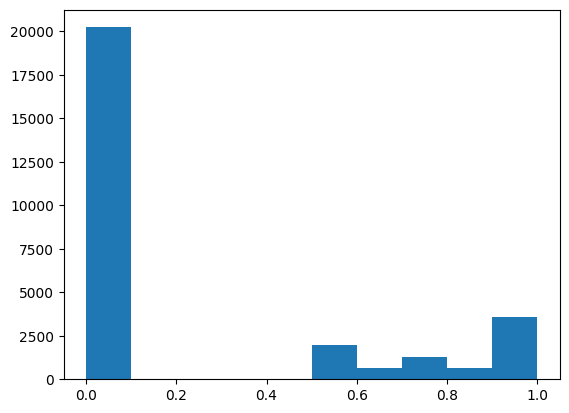

In [25]:
import matplotlib.pyplot as plt
plt.hist(anls_after)

In [26]:
from copy import copy
train_batch = copy(batch)

In [27]:
train_batch_forward = forward(train_batch)

In [28]:

from IPython.display import display
from PIL import Image
image_mean = image_processor.image_mean
image_std = image_processor.image_std
for i in range(10):
    answer = train_batch["labels"][i].to(device)
    predict = text_processor.decode(train_batch_forward[i],skip_special_tokens=True)
    ground_truth = text_processor.decode(answer,skip_special_tokens=True)
    print("Question:",text_processor.decode(train_batch['input_ids'][i],skip_special_tokens=True))
    print(predict,"|",ground_truth)

Question: how many cubic meters of gas sales did eni sp. a. have in italy in 2019?
0. 71 | 37. 85
Question: how many countries are shown on this graph?
5 | 2
Question: what country did 7 percent of travel agents say their clients chose to honeymoon in in 2014?
spain | europe
Question: what was the top - grossing puzzle game worldwide in february 2021?
homescapes | homescapes
Question: what percentage of children aged between 11 and 15 had participated in horse riding or pony trekking in the 4 weeks prior to the survey?
6. 3 | 3. 7
Question: how much money did new york lose to the ic3?
81. 8 | 415. 81
Question: how many users has pandora lost in the last two years?
10. 5 | 58. 58
Question: how many bars are there in the graph?
3 | 3
Question: what was the employment rate of men in the u. s. in 2020?
65. 4 | 62. 4
Question: what was vanuatu's gross domestic product in dollars in 2018?
0. 98 | 0. 93


#### Тест

In [29]:
anls_after = list()
model.to(device)
for batch in tqdm(iter(test)):
    answer = batch["labels"].to(device)
    predict = [text_processor.decode(text,skip_special_tokens=True) for text in forward(batch)]
    ground_truth = [text_processor.decode(text,skip_special_tokens=True) for text in answer]
    score = [anls_score(prediction=text1, gold_labels=[text2], threshold=0.5) for text1,text2 in zip(predict,ground_truth)]
    anls_after.extend(score)

  0%|          | 0/16 [00:00<?, ?it/s]

In [30]:
test_batch = copy(batch)

In [31]:
test_batch_forward = forward(test_batch)

In [32]:

from IPython.display import display
from PIL import Image
image_mean = image_processor.image_mean
image_std = image_processor.image_std
for i in range(10):
    answer = test_batch["labels"][i].to(device)
    predict = text_processor.decode(test_batch_forward[i],skip_special_tokens=True)
    ground_truth = text_processor.decode(answer,skip_special_tokens=True)
    print("Question:",text_processor.decode(test_batch['input_ids'][i],skip_special_tokens=True))
    print(predict,"|",ground_truth)

Question: who portrayed jon snow?
0. 01 | kit harington
Question: who played mother of dragons daenerys targaryen?
targaryen lannister | emilia clarke
Question: what was the estimated net worth of peter dinklage and nikolaj coster - waldau?
51. 5 | 16
Question: what is the most popular cross - platform mobile framwork used by global developers?
google home | react native
Question: when did the population of the dominican republic begin to increase?
2000 | 2008
Question: what was the population of the dominican republic in 2018?
10. 5 | 10. 63
Question: which supreme court justice did 32 percent of respondents not know if they had a favorable or unfavorable opinion of?
hillary clinton | brett kavanaugh
Question: when did the population of antigua & barbuda begin to increase?
2000 | 2008
Question: how many macy's branded stores did macy's operate in 2020?
583 | 572
Question: how many bluemercury stores did macy's operate in 2020?
533 | 162


In [33]:
np.mean(anls_after)

0.11839487179487179

(array([857.,   0.,   0.,   0.,   0.,  28.,   9.,  34.,   9.,  63.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

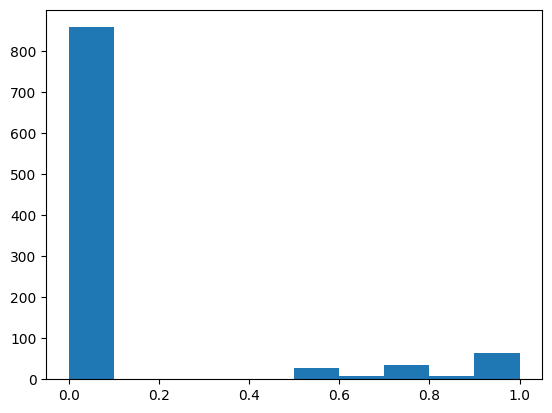

In [34]:
import matplotlib.pyplot as plt
plt.hist(anls_after)

**Итог: Наблюдается очевидное переобучение под обучающие данные, разрыв в метриках на валидации и трейне достаточно заметен. Исправить переобучение не удалось, однако почитав в интернете выяснил, что BLIP может переобучаться на конкретных задачах.** 

**UPD: итог выше был основан на обучении на 8-10 эпохах. Перелом происходит после 2 эпохи.**